# LSTM on Donors Choose data for classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train_data.csv')

In [3]:
train_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


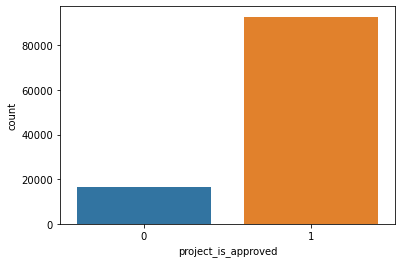

In [4]:
sns.countplot(train_data['project_is_approved'])
plt.show()

- Imbalanced output.

In [5]:
resources_data = pd.read_csv('resources.csv')
resources_data.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [6]:
train_data.isnull().sum()

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       3
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

- Some NaN values can be observed in the column **teacher_prefix**
- A huge number of NaN values can be observed in the essage columns **3** and **4**

## 1. *Preprocessing categorical feature:* **project_grade_category**
- Convert into lowercase
- Replace spaces with '_'
- Replace '-' with '_'

In [7]:
def preprocess_project_grade_category(document):
  document = document.lower()
  document = document.replace(' ', '_')
  document = document.replace('-', '_')
  return document

train_data['project_grade_category'] = train_data['project_grade_category'].apply(preprocess_project_grade_category)

## 2. *Preprocess:* **project_subject_categories**
- Convert into lowercase
- Replace spaces.
- Remove 'the'
- Replace '&' and ',' with '_'

In [8]:
def preprocess_project_subject_categories(document):
  document = document.lower()
  document = document.replace(' the ', '')
  document = document.replace(' ', '')
  document = document.replace('&', '_')
  document = document.replace(',', '_')
  return document

train_data['project_subject_categories'] = train_data['project_subject_categories'].apply(preprocess_project_subject_categories)

## 3. *Preprocess:* **teacher_prefix**
- Checking for NaN values.
- Converting into lowercase.
- Remove '.'

In [9]:
train_data['teacher_prefix'].isnull().sum()

3

In [10]:
mode = train_data['teacher_prefix'].mode()
train_data['teacher_prefix'] = train_data['teacher_prefix'].fillna(value = mode[0])
train_data['teacher_prefix'] = train_data['teacher_prefix'].str.lower()
train_data['teacher_prefix'] = train_data['teacher_prefix'].str.replace('.', '')

## 4. *Preprocess:* **project_subject_subcategories**`

In [11]:
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].apply(preprocess_project_subject_categories)

## 5. *Preprocess:* **school_state**
- Convert into small letters.

In [12]:
train_data['school_state'] = train_data['school_state'].str.lower()

*Combining the essay based columns into one.*

In [13]:
train_data['combined_essay'] = train_data['project_essay_1'] + ' ' + train_data['project_essay_2'] + ' ' + train_data['project_essay_3'].fillna(value = ' ') + ' ' + train_data['project_essay_4'].fillna(value = ' ')

In [14]:
def preprocess_text(document):
  # Converting into lower
  document = document.lower()

  # Decontraction
  document = re.sub(r"won't", "will not", document)
  document = re.sub(r"can\'t", "can not", document)
  document = re.sub(r"n\'t", " not", document)
  document = re.sub(r"\'re", " are", document)
  document = re.sub(r"\'s", " is", document)
  document = re.sub(r"\'d", " would", document)
  document = re.sub(r"\'ll", " will", document)
  document = re.sub(r"\'t", " not", document)
  document = re.sub(r"\'ve", " have", document)
  document = re.sub(r"\'m", " am", document)

  # Removing some specific characters
  document = document.replace('\\n', '')
  document = document.replace('\\r', '')
  document = document.replace('\\"', '')

  # Remove all characters except a-zA-Z0-9
  document = re.sub(r'[^a-zA-Z0-9]+', ' ', document)

  return document

In [15]:
train_data['combined_essay'] = train_data['combined_essay'].apply(preprocess_text)

In [16]:
resources_data.head(10)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95
5,p069063,Last to Finish: A Story About the Smartest Boy...,1,16.99
6,p069063,"Mrs. Gorski, I Think I Have the Wiggle Fidgets...",1,9.95
7,p069063,"See-N-Read 1503905CQ Reading Tool - Book Size,...",2,10.11
8,p096795,"Brewster WPD90218 Wall Pops Flirt Dot, Set of ...",2,9.95
9,p096795,Brewster Wall Pops WPE99065 Peel & Stick Calyp...,2,9.02


In [17]:
resources_data.shape

(1541272, 4)

In [18]:
resources_data['id'].value_counts()

p009778    100
p066966    100
p137603    100
p121858     99
p143469     99
          ... 
p138769      1
p211521      1
p219148      1
p103662      1
p233245      1
Name: id, Length: 260115, dtype: int64

In [19]:
resources_data = resources_data.groupby('id')['quantity', 'price'].sum().reset_index()
resources_data.head()

,id,quantity,price
0,p000001,7,459.56
1,p000002,21,515.89
2,p000003,4,298.97
3,p000004,98,1113.69
4,p000005,8,485.99


In [20]:
combined_df = pd.merge(left = train_data, right = resources_data, on = 'id', how = 'left')

Considering the following columns for making preidctions:
- **combined_essay**
- **school_state**
- **project_grade_category**
- **project_subject_categories**
- **project_subject_subcategories**
- **teacher_prefix**
- **teacher_number_of_previously_posted_projects**
- **price**
- **quantity**

In [21]:
final_df = combined_df[['combined_essay', 'school_state', 'project_grade_category', 'project_subject_categories', 
                        'project_subject_subcategories', 'teacher_prefix', 'teacher_number_of_previously_posted_projects',
                        'price', 'quantity', 'project_is_approved']]

In [22]:
final_df.head()

,combined_essay,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_prefix,teacher_number_of_previously_posted_projects,price,quantity,project_is_approved
0,my students are english learners that are work...,in,grades_prek_2,literacy_language,esl_literacy,mrs,0,154.60,23,0
1,our students arrive to our school eager to lea...,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,mr,7,299.00,1,1
2,true champions are not always the ones that wi...,az,grades_6_8,health_sports,health_wellness_teamsports,ms,1,516.85,22,0
3,i work at a unique school filled with both esl...,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,mrs,4,232.90,4,1
4,our second grade classroom next year will be m...,tx,grades_prek_2,math_science,mathematics,mrs,1,67.98,4,1


*Using* **LabelEncoder** *on categorical columns:*
- **school_state**
- **project_grade_category**
- **project_subject_categories**
- **project_subject_subcategories**

In [23]:
from sklearn.preprocessing import LabelEncoder
le_school_state = LabelEncoder()
le_project_grade_category = LabelEncoder()
le_project_subject_categories = LabelEncoder()
le_project_subject_subcategories = LabelEncoder()

categorical_cols = ['school_state', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories']

school_state = le_school_state.fit_transform(final_df['school_state'])
project_grade_category = le_project_grade_category.fit_transform(final_df['project_grade_category'])
project_subject_categories = le_project_subject_categories.fit_transform(final_df['project_subject_categories'])
project_subject_subcategories = le_project_subject_subcategories.fit_transform(final_df['project_subject_subcategories'])

In [24]:
categorical_data = pd.DataFrame(school_state, columns = ['school_state'])
categorical_data['project_grade_category'] = project_grade_category
categorical_data['project_subject_categories'] = project_subject_categories
categorical_data['project_subject_subcategories'] = project_subject_subcategories

*Combining the data as follows*

In [25]:
num_data_cols = ['price', 'quantity', 'teacher_number_of_previously_posted_projects']
df = pd.concat([final_df['combined_essay'], categorical_data, final_df[num_data_cols]], axis = 1)

In [26]:
df['project_is_approved'] = final_df['project_is_approved']

In [27]:
df.head()

,combined_essay,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,price,quantity,teacher_number_of_previously_posted_projects,project_is_approved
0,my students are english learners that are work...,15,3,24,197,154.60,23,0,0
1,our students arrive to our school eager to lea...,9,1,18,77,299.00,1,7,1
2,true champions are not always the ones that wi...,3,1,8,301,516.85,22,1,0
3,i work at a unique school filled with both esl...,17,3,28,319,232.90,4,4,1
4,our second grade classroom next year will be m...,43,3,32,342,67.98,4,1,1


*Splitting the data into train and test set and making the data model-ready as follows*

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('project_is_approved', axis = 1), df['project_is_approved'],
                                                    random_state = 10, stratify = df['project_is_approved'])

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train['combined_essay'])

train_essay_tokenizer = tokenizer.texts_to_sequences(X_train['combined_essay'])
test_essay_tokenizer = tokenizer.texts_to_sequences(X_test['combined_essay'])

In [30]:
l = []
for i in X_train['combined_essay']:
  l.append(len(i.split()))

pd.DataFrame(l).describe(percentiles = [0.25, 0.75, 0.9, 0.1]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
0,81936.0,259.517404,66.619906,126.0,191.0,207.0,241.0,297.0,358.0,529.0


In [31]:
X_train_essay_padded = pad_sequences(train_essay_tokenizer, maxlen = 297, padding = 'post')
X_test_essay_padded = pad_sequences(test_essay_tokenizer, maxlen = 297, padding = 'post')

In [32]:
import pickle 

with open('glove_vectors', 'rb') as f:
    glove_vectors = pickle.load(f)
    glove_words =  set(glove_vectors.keys())

In [33]:
vocab_size = len(tokenizer.word_index)
embedding_matrix = np.zeros(shape = (vocab_size + 1, 300))
for word, index in tokenizer.word_index.items():
  embedding_vector = glove_vectors.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

*Standardizing the numerical columns.*

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[num_data_cols] = scaler.fit_transform(X_train[num_data_cols])
X_test[num_data_cols] = scaler.transform(X_test[num_data_cols])

In [35]:
X_train.head()

,combined_essay,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,price,quantity,teacher_number_of_previously_posted_projects
79994,my students are three and four years old and p...,34,3,36,17,-0.317280,-0.456577,1.255421
48703,hello i teach at a public charter school in ci...,35,1,36,174,-0.009404,-0.608427,-0.400656
59827,i am proud to teach at our school in howe idah...,13,0,8,396,2.095833,0.264711,-0.076641
34841,our first day of the new school year is in the...,42,0,8,256,1.176502,-0.532502,0.031364
9572,i teach a wonderfully eager group of second gr...,4,3,24,317,-0.024950,-0.570464,-0.364654


## Model 1

In [36]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import LSTM, Dense, concatenate, Embedding, Flatten, Concatenate, Dropout, Conv1D
from keras.models import Model, Input

In [37]:
from tensorflow_addons.metrics import F1Score
from keras.metrics import AUC

In [38]:
input_essay = Input(shape = (297,))
embedding_essay = Embedding(input_dim = vocab_size+1, output_dim = 300, weights = [embedding_matrix], input_length = 297)(input_essay)
lstm_1 = LSTM(units = 64, return_sequences = True)(embedding_essay)
flatten_essay = Flatten()(lstm_1)

input_school_state = Input(shape = (1,))
embedding_school_state = Embedding(input_dim = len(set(school_state))+1, output_dim = 100, input_length = 1)(input_school_state)
flatten_school_state = Flatten()(embedding_school_state)

input_project_grade_category = Input(shape = (1,))
embedding_project_grade_category = Embedding(input_dim = len(set(project_grade_category))+1, output_dim = 100, input_length = 1)(input_project_grade_category)
flatten_project_grade_category = Flatten()(embedding_project_grade_category)

input_project_subject_categories = Input(shape = (1,))
embedding_project_subject_categories = Embedding(input_dim = len(set(project_subject_categories))+1, output_dim = 100, input_length = 1)(input_project_subject_categories)
flatten_project_subject_categories = Flatten()(embedding_project_subject_categories)

input_project_subject_subcategories = Input(shape = (1,))
embedding_project_subject_subcategories = Embedding(input_dim = len(set(project_subject_subcategories))+1, output_dim = 100, input_length = 1)(input_project_subject_subcategories)
flatten_project_subject_subcategories = Flatten()(embedding_project_subject_subcategories)

input_num = Input(shape = (3,))
dense_num = Dense(64, activation = 'relu', kernel_initializer = 'glorot_normal')(input_num)

concatenate_layer = concatenate([flatten_essay, flatten_school_state, flatten_project_grade_category, flatten_project_subject_categories, flatten_project_subject_subcategories, dense_num])

dense_1 = Dense(units = 64, activation = 'relu')(concatenate_layer)
dropout_1 = Dropout(0.3)(dense_1)

dense_2 = Dense(units = 64, activation = 'relu')(dropout_1)
dropout_2 = Dropout(0.3)(dense_2)

dense_3 = Dense(32, activation = 'relu')(dropout_2)

output_layer = Dense(units = 1, activation = 'sigmoid')(dense_3)

model_1 = Model(inputs = [input_essay, input_school_state, input_project_grade_category, input_project_subject_categories, input_project_subject_subcategories, input_num], 
                outputs = output_layer)

In [39]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 297)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 297, 300)     15316500    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [40]:
train_input = [X_train_essay_padded, X_train['school_state'], X_train['project_grade_category'], X_train['project_subject_categories'],
               X_train['project_subject_subcategories'], X_train[num_data_cols]]

val_input = [X_test_essay_padded, X_test['school_state'], X_test['project_grade_category'], X_test['project_subject_categories'], 
             X_test['project_subject_subcategories'], X_test[num_data_cols]]

model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [AUC()])
performance = model_1.fit(x = train_input, y=y_train, epochs = 10, validation_data = (val_input, y_test), batch_size = 100)

Epoch 1/10
820/820 [==============================] - 715s 870ms/step - loss: 0.3885 - auc: 0.7138 - val_loss: 0.3853 - val_auc: 0.7768
Epoch 2/10
820/820 [==============================] - 666s 812ms/step - loss: 0.3358 - auc: 0.8096 - val_loss: 0.3624 - val_auc: 0.7661
Epoch 3/10
820/820 [==============================] - 660s 805ms/step - loss: 0.2468 - auc: 0.9086 - val_loss: 0.4254 - val_auc: 0.7154
Epoch 4/10
820/820 [==============================] - 672s 820ms/step - loss: 0.1144 - auc: 0.9811 - val_loss: 0.6479 - val_auc: 0.6795
Epoch 5/10
820/820 [==============================] - 676s 825ms/step - loss: 0.0507 - auc: 0.9954 - val_loss: 0.9594 - val_auc: 0.6566
Epoch 6/10
820/820 [==============================] - 679s 828ms/step - loss: 0.0319 - auc: 0.9977 - val_loss: 1.1738 - val_auc: 0.6552
Epoch 7/10
820/820 [==============================] - 722s 881ms/step - loss: 0.0233 - auc: 0.9985 - val_loss: 1.2867 - val_auc: 0.6476
Epoch 8/10
820/820 [============================